In [1]:
!pip install torchaudio transformers librosa soundfile faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.3 MB/s eta 0:00:00


In [2]:
import torch
import torchaudio
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, AutoModel, AutoFeatureExtractor
from transformers import AutoFeatureExtractor, ASTFeatureExtractor, ASTForAudioClassification, ASTModel
from IPython.display import Audio, display
import librosa
import soundfile as sf
import os
import faiss

In [3]:
# Load the Wav2Vec2.0 tokenizer and model
model = AutoModel.from_pretrained('facebook/wav2vec2-base-960h')
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

feature_extractor_ast = AutoFeatureExtractor.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')
model_ast = ASTModel.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 were not used when initializing ASTModel: ['classifier.layernorm.bias', 'classifier.dense.bias', 'classifier.layernorm.weight', 'classifier.dense.weight']
- This IS expected if you are initializing ASTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ASTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
torch.cuda.is_available()

False

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
waveform, sample_rate = torchaudio.load('/content/drive/MyDrive/music-llm/raw/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav')
waveform = waveform.squeeze().numpy()

print(sample_rate)

16000


In [7]:
display(Audio(waveform, rate=sample_rate))
print()

In [8]:

dest_dir = '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/'

In [9]:
len(os.listdir(dest_dir))


10520

In [10]:
import pickle

In [11]:
with open('/content/drive/MyDrive/music-llm/index_lookup_sample.pkl', 'rb') as f:
  faiss_index_lookup_samples = pickle.load(f)

In [12]:
index_wav_vec = faiss.read_index('/content/drive/MyDrive/music-llm/10sec_sample_index_wav2vec.index')
index_ast = faiss.read_index('/content/drive/MyDrive/music-llm/10sec_sample_index_ast.index')

In [13]:
index_wav_vec.ntotal

10519

In [14]:
index_ast.ntotal

10519

In [15]:
model.to('cuda:0')
model_ast.to('cuda:0')

RuntimeError: ignored

## Testing FAISS similarity

In [16]:

fprefix = '/content/drive/MyDrive/music-llm/'

In [17]:

inp_file = f'{fprefix}raw/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav'
inp_file

'/content/drive/MyDrive/music-llm/raw/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav'

In [24]:


waveform, sample_rate = torchaudio.load(inp_file)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()
# input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
input_values = feature_extractor(waveform, return_tensors="pt", sampling_rate=16000)
embeddings_wav = model(**input_values).last_hidden_state
embeddings_wav = embeddings_wav.mean(dim=1)

# input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000).to('cuda:0')
input_values = feature_extractor_ast(waveform, return_tensors="pt", sampling_rate=16000)
embeddings_ast = model_ast(**input_values).last_hidden_state
embeddings_ast = embeddings_ast.mean(dim=1)

In [25]:
D, I = index_wav_vec.search(embeddings_wav.to('cpu').detach().numpy(), k=10)
D_ast, I_ast = index_ast.search(embeddings_ast.to('cpu').detach().numpy(), k=10)

In [26]:
print(D)
print(D_ast)

[[1.2858446e-10 6.0744047e-01 7.4465573e-01 7.5521141e-01 7.6324111e-01
  8.2263511e-01 8.3792448e-01 8.5037684e-01 8.6492640e-01 8.7196249e-01]]
[[2.1511280e-10 2.2494356e+01 3.4997749e+01 5.0722565e+01 5.2236027e+01
  6.4904686e+01 7.9568054e+01 7.9960976e+01 8.0270950e+01 8.3592979e+01]]


In [27]:
matched_file_wav = faiss_index_lookup_samples[I[0][1]]
matched_file_ast = faiss_index_lookup_samples[I_ast[0][1]]

In [28]:
print(inp_file, matched_file_wav, matched_file_ast)

/content/drive/MyDrive/music-llm/raw/10_seconds_samples/1000_KW20 - Various Artists.mp3.wav /content/drive/MyDrive/music-llm/raw/10_seconds_samples/450_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav /content/drive/MyDrive/music-llm/raw/10_seconds_samples/1010_KW20 - Various Artists.mp3.wav


In [29]:
waveform, sample_rate = torchaudio.load(inp_file)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

In [30]:
print("Matched file wav2vec {}".format(matched_file_wav))
waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Matched file wav2vec /content/drive/MyDrive/music-llm/raw/10_seconds_samples/450_Ben Böhmer Feat. Wood & Simon Krause - Give Me (Original Mix).mp3.wav


In [31]:
print("Matched file ast {}".format(matched_file_ast))

waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()
display(Audio(waveform, rate=sample_rate))
print()

Matched file ast /content/drive/MyDrive/music-llm/raw/10_seconds_samples/1010_KW20 - Various Artists.mp3.wav


## Visualising the 2 the indices, creating a dataset with Huggingface Datasets

In [32]:
import matplotlib.pyplot as plot

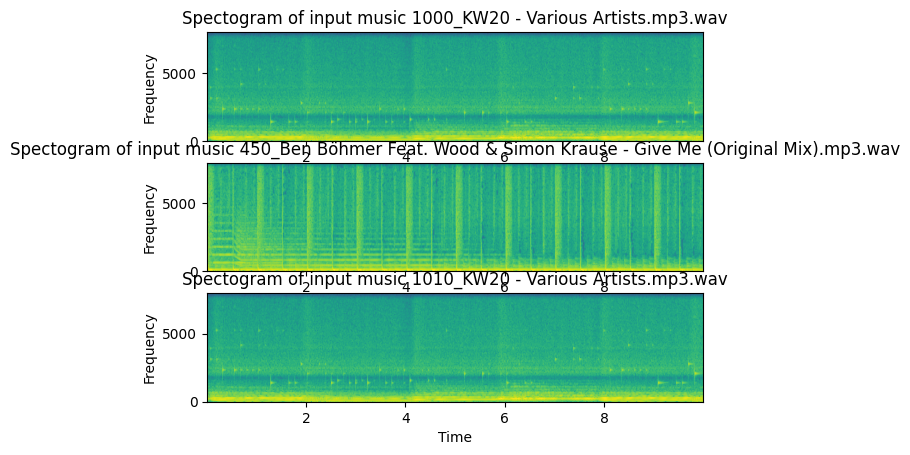

In [33]:

# Plot the signal read from wav file

# plt.subplots(nrows=3, ncols=1,)
plot.subplot(311)
plot.title('Spectogram of input music {}'.format(inp_file.split('/')[-1]))
plot.specgram(waveform,Fs=16000)
plot.xlabel('Time')
plot.ylabel('Frequency')

plot.subplot(312)
waveform, sample_rate = torchaudio.load(matched_file_wav)
waveform = waveform.squeeze().numpy()
plot.title('Spectogram of input music {}'.format(matched_file_wav.split('/')[-1]))
plot.specgram(waveform,Fs=16000)
plot.xlabel('Time')
plot.ylabel('Frequency')

plot.subplot(313)
waveform, sample_rate = torchaudio.load(matched_file_ast)
waveform = waveform.squeeze().numpy()
plot.title('Spectogram of input music {}'.format(matched_file_ast.split('/')[-1]))
plot.specgram(waveform,Fs=16000)
plot.xlabel('Time')
plot.ylabel('Frequency')


plot.show()

 

In [34]:
# !pip uninstall "docarray[full]" -y
!pip install docarray[full]==0.21.0
import docarray
docarray.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.0/658.0 kB 19.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.1/681.1 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.0/31.0 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.6/241.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

'0.21.0'

In [51]:

index_wav_vec.ntotal

10519

In [52]:
import numpy as np
from docarray import DocumentArray
from docarray import base

docs = DocumentArray.empty(index_wav_vec.ntotal)

In [53]:
docs.embeddings

In [54]:
embeddings_ast = np.load('/content/drive/MyDrive/music-llm/emb_ast.npz', 'r')

In [55]:

embeddings_ast = embeddings_ast['arr_0']

In [56]:
embeddings_wav = np.load('/content/drive/MyDrive/music-llm/emb_wav.npz', 'r')
embeddings_wav = embeddings_wav['arr_0']

In [57]:

embeddings_wav.shape

(10519, 768)

In [58]:
docs.embeddings = embeddings_wav

In [59]:

docs.summary()

╭─────────────── Documents Summary ────────────────╮
│                                                  │
│   Type                   DocumentArrayInMemory   │
│   Length                 10519                   │
│   Homogenous Documents   True                    │
│   Common Attributes      ('id', 'embedding')     │
│   Multimodal dataclass   False                   │
│                                                  │
╰──────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   10519            False             │
│   id          ('str',)       10519            False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [60]:

with open('/content/drive/MyDrive/music-llm/index_lookup_sample.pkl', 'rb') as f:
  faiss_index_lookup_samples = pickle.load(f)

In [61]:
ids = list(faiss_index_lookup_samples.values())
ids[:10]

['/content/drive/MyDrive/music-llm/raw/10_seconds_samples/320_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav',
 '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/110_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav',
 '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/280_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav',
 '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/300_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav',
 '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/410_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav',
 '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/150_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav',
 '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/30_Dave Seaman - Virgo Ryzin (Joeski Remix) [Selador] #tupremiere.mp3.wav',
 '/content/drive/MyDrive/music-llm/raw/10_seconds_sample

In [62]:

docs.id = ids

In [64]:


for i, doc in enumerate(docs):
  doc.id = ids[i].split('/')[-1]

In [67]:

print(docs[11].id)
print(docs[12].id)

310_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
190_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav


In [70]:

docs.summary()

╭─────────────── Documents Summary ────────────────╮
│                                                  │
│   Type                   DocumentArrayInMemory   │
│   Length                 10519                   │
│   Homogenous Documents   True                    │
│   Common Attributes      ('id', 'embedding')     │
│   Multimodal dataclass   False                   │
│                                                  │
╰──────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('ndarray',)   10519            False             │
│   id          ('str',)       10519            False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯

In [ ]:
docs.plot_embeddings()

In [71]:
inv_faiss_index_lookup_samples = {}
for k in faiss_index_lookup_samples.keys():
  v = faiss_index_lookup_samples[k]
  inv_faiss_index_lookup_samples[v] = k

In [76]:
fprefix = '/content/drive/MyDrive/music-llm/raw/10_seconds_samples/'

In [77]:

inv_faiss_index_lookup_samples[f'{fprefix}310_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav']

11

In [79]:
docs[11]

📄 Document: 310_Lee Burridge and Matthew Dekay - WONGEL.mp3.wav
╭───────────┬──────────────────────────────────────────────────────────────────╮
│ Attribute │ Value                                                            │
├───────────┼──────────────────────────────────────────────────────────────────┤
│ embedding │ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ │
│           │ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ │
│           │ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ │
│           │ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ │
│           │ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ │
│           │ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄ │
│           │ ▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄

In [110]:
matches = docs.find(docs[900], limit=30, distance='cosine')

In [111]:
print(matches[0][0].id, matches[0][0].scores)
print(matches[0][1].id, matches[0][0].scores)
print(matches[0][2].id, matches[0][0].scores)


240_Open Your Eyes.mp3.wav defaultdict(<class 'docarray.score.NamedScore'>, {'cosine': {'value': 0.0}})
220_Caribou - Mars.mp3.wav defaultdict(<class 'docarray.score.NamedScore'>, {'cosine': {'value': 0.0}})
210_TB PREMIERE: Denney & D.Ramirez - Stranger Things [Crosstown Rebels].mp3.wav defaultdict(<class 'docarray.score.NamedScore'>, {'cosine': {'value': 0.0}})


In [106]:
matches = docs.find(docs[100], limit=30, distance='cosine')

In [107]:
print(matches[0][0].id, matches[0][0].scores)
print(matches[0][1].id, matches[0][0].scores)
print(matches[0][19].id, matches[0][0].scores)


120_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav defaultdict(<class 'docarray.score.NamedScore'>, {'cosine': {'value': 5.9604645e-08}})
110_Made By Pete - Safe House ft. Penny F (Original Mix) [Gruuv] [MI4L.com].mp3.wav defaultdict(<class 'docarray.score.NamedScore'>, {'cosine': {'value': 5.9604645e-08}})
240_CamelPhat, Cari Golden - Temperament Of The Beat.mp3.wav defaultdict(<class 'docarray.score.NamedScore'>, {'cosine': {'value': 5.9604645e-08}})
